# **Extended SSH Bound States**

**Spatial distribution of Bound States Wavefunctions**

In this notebook we outline the code used for the numerical computation of the bound states that emerge when coupling a quantum emitter to an extended SSH photonic lattice. For this purpose, we will diagonalize the hamiltonian of the system
\begin{equation}
\mathcal{H} = \mathcal{H}_\text{ eSSH} + g\left(a_0^\dagger \sigma_{ge} + h.c.\right)\;,
\end{equation}
where $\mathcal{H}_\text{ eSSH}$ denotes the extended SSH bath hamiltonian, $a_0^\dagger$ is the creation operator of a one-photon state on the site $0$ of the lattice, and $\sigma_{ge}=|e\rangle\langle g|$.

In [ ]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)

# Dictionary of hopping amplitudes in different topological phases, all
# reproducing the same band-gap width of E_g /J = 0.21
winding_to_hoppings = {'-1': (1,1,0.8,0.5), '1':(1,1,0.5,0.5-0.2339),
                    '2': (1,1,0.5,0.8), '0': (1,1,0.5-0.2339,0.5)}

We start by writing a function that diagonalizes this hamiltonian within the single excitation subspace, spanned by $\left\lbrace |e\rangle|\text{vac}\rangle,\;|g\rangle|1_j\rangle \right\rbrace\,,$ being $|\text{vac}\rangle$ the lattice vacuum state and $|1_j\rangle$ the Fock state with a single photon localized at site $j$ of the lattice.

We will add disorder terms to the bath hamiltonian hopping amplitudes, aiming to analyse bound state robustness. This disordered terms will follow a gaussian distribution with zero mean and standard deviaiton $\sigma$, which plays the role of disorder strengh:
\begin{equation}
J_i \longrightarrow J_i + \varepsilon_i \quad,\quad \mathbb{P}\left\lbrace\varepsilon_i = \alpha\right\rbrace = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\alpha^2/2\sigma^2}
\end{equation}

In [ ]:
def diagonalize_disordered_hamiltonian(hoppings, g, Delta, N_cells, sigma, dis):
    """
    Returns the spectrum and eigenstates of the extended SSH bath hamiltonian
    with a lattice size od 2*N_cells, and gaussian disorder that either 
    preserves or break chiral symmetry (depending of the 'dis' argument) and
    a disorder strength sigma. The QE is coupled at a detuning Delta.

    Inputs
    --------------------
    hoppings: Values of hopping amplitudes (list)
    g: QE-field coupling constant (float)
    Delta: QE Detuning with respect of reference energy (float)
    N_cells: Number of unit cells of the lattice (integer)
    sigma: Disorder strength (float)
    dis: Disorder type, either 'preserving' or 'breaking' (string)

    Outputs
    --------------------
    omega: Energy spectrum of the total hamiltonian H = H_bath + H_QE + H_int
    C: Eigenstates of H
    """

    # Retrieve hoppings from list
    t1, t2, r1, r2 = hoppings
    
    # We start by builing the bath hamiltonian
    
    M = 2*N_cells
    H = np.zeros( (M+1, M+1) )
    H_b = np.zeros( (M, M) )
    
    for i in range(M-3):
        
        if i%2 == 0:
        
            H_b[i, i+1] = t1 
            H_b[i, i+3] = r1 
            
            # Add disorder, depending on if it preserves chiral symmetry
            # or not. 
            
            if dis == 'preserving':
               # Symmetry-preserving case: disorder odd-hoppings
               H_b[i, i+1] += sigma*np.random.randn()
               H_b[i, i+3] += sigma*np.random.randn()
               
            if dis == 'breaking':
               # Symmetry-breaking case: disorder diagonal/even hoppings
               H_b[i, i] += sigma*np.random.randn()
               H_b[i, i+2] += sigma*np.random.randn()
            
            # Impose hermiticity
            H_b[i+1, i], H_b[i+3, i] = H_b[i, i+1], H_b[i, i+3]
            H_b[i+2,i] = H_b[i, i+2]
            
        else:
            
            H_b[i, i+1] = t2
            H_b[i, i+3] = r2
            
            if dis == 'preserving':
               H_b[i, i+1] += sigma*np.random.randn()
               H_b[i, i+3] += sigma*np.random.randn()
               
            if dis == 'breaking':
               H_b[i, i] += sigma*np.random.randn()
               H_b[i, i+2] += sigma*np.random.randn()
            
            # Impose hermiticity
            H_b[i+1, i], H_b[i+3, i] = H_b[i, i+1], H_b[i, i+3]
            H_b[i+2,i] = H_b[i, i+2]
            
    # Regarding the right edge:
    
    H_b[M-3, M-2] = t2 + sigma*np.random.randn() 
    H_b[M-2, M-1] = t1 + sigma*np.random.randn()
    H_b[M-2, M-3], H_b[M-1, M-2] = H_b[M-3, M-2], H_b[M-2, M-1]

    # Coupling the emitter in the first dimension of the hamiltonian
    em = np.zeros((M+1))
    em[0] = Delta
    em[N_cells-1] = g
    H[0, :], H[:, 0] = em, em
    H[1:, 1:] = H_b
    
    # Diagonalizing the hamiltonian
    omega, C = LA.eigh(H)

    return omega, C

We now proceed to retrieve the bound state from the spectrum. If there is no disorder in the bath hamiltonian (or if it is weak), this can be achieved picking the eigenstate that maximizes the quantum emitter population:
\begin{equation}
\text{BS}_\text{index} = \text{argmax}\left(|\Psi_e|^2\right)\;,
\end{equation}
being $\Psi$ a generic eigenstate $\Psi_e = \langle e|\Psi\rangle$.

In [ ]:
def bound_state(winding, g, Delta, N_cells, sigma, dis):
    """
    Returns the bound state coefficients by selecting the eigenstate
    that maximizes the QE population.

    Inputs
    --------------------
    winding: Winding number that determines the topological phase (integer)
    g: QE-field coupling constant (float)
    Delta: QE Detuning with respect of reference energy (float)
    N_cells: Number of unit cells of the lattice (integer)
    sigma: Disorder strength (float)
    dis: Disorder type, either 'preserving' or 'breaking' (string)

    Outputs
    --------------------
    psi: Bound state in the single excitation subspace basis
    """
    # Retrieve hoppings from dictionary and diagonalize
    hoppings = winding_to_hoppings[str(winding)]
    omega, C = diagonalize_disordered_hamiltonian(hoppings, g, Delta, 
                                                  N_cells, sigma, dis)
    # Get index of the bound state
    BS_index = np.argmax(abs(C[0,:])**2) 

    return C[:, BS_index], BS_index

Let's visualize an example in absence of disorder, for a lattice size of $300$ cells, a coupling constant $g/J=0.4$ and zero-detuning.

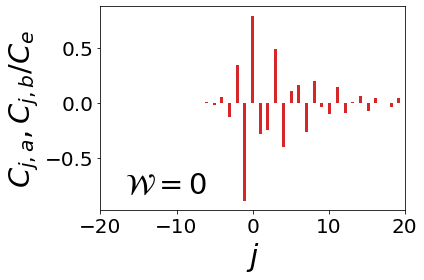

In [ ]:
winding, N_cells, g, Delta, sigma, dis = 0, 300, 0.4, 0, 0, None

psi, index = bound_state(winding, g, Delta, N_cells, sigma, dis)

# Pick indices of each sublattice
indices_a = np.arange(1, 2*N_cells, 2)
indices_b = 1 + indices_a
Cb = np.take(psi, indices_b)
Ca = np.take(psi, indices_a)

# Drop the emitter population coordinate and normalize
Cb, Ca = Cb[1:]/psi[0], Ca[1:]/psi[0]

# Plot the resulting state
fig, ax = plt.subplots()

# Represent around the emitter location
ent = 40
a = N_cells//2 - ent
b = N_cells//2 + ent
j_vals = np.linspace(-ent, ent, len(Ca[a:b]))

ax.bar(j_vals, Ca[a:b], 0.4, color='C0')
ax.bar(j_vals + 0.5, Cb[a:b], 0.4, color='C3')
ax.set_xlim([-ent//2, ent//2])
bottom, top = ax.get_ylim()
ax.set_ylim([bottom - (top - bottom)*0, top])
ax.text(0.08, 0.08, '$\mathcal{W}=0$', transform=ax.transAxes, fontsize=29)
ax.set_xlabel('$j$', fontsize=30)
ax.set_ylabel('$C_{j,a}, C_{j,b}/C_e$', fontsize=29)
plt.tight_layout()

With these functions we can visualize as well the wavefunction distribution of bound states in the presence of disorder that either respects or not the chiral symmetry of the bath hamiltonian.

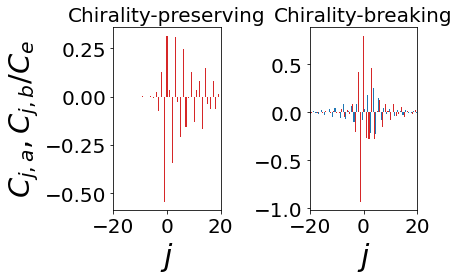

In [ ]:
# Compute bound states with disorder of both types
psi, index = bound_state(winding, g, Delta, N_cells, 0.1, 'preserving')
psi2, index2 = bound_state(winding, g, Delta, N_cells, 0.1, 'breaking')

# Pick indices of each sublattice
indices_a = np.arange(1, 2*N_cells, 2)
indices_b = 1 + indices_a
Cb = np.take(psi, indices_b)
Ca = np.take(psi, indices_a)
Cb2 = np.take(psi2, indices_b)
Ca2 = np.take(psi2, indices_a)

# Drop the emitter population coordinate and normalize
Cb, Ca = Cb[1:]/psi[0], Ca[1:]/psi[0]
Cb2, Ca2 = Cb2[1:]/psi2[0], Ca2[1:]/psi2[0]

# Plot the resulting state
fig, axes = plt.subplots(ncols=2)

# Represent around the emitter location
ent = 40
a = N_cells//2 - ent
b = N_cells//2 + ent
j_vals = np.linspace(-ent, ent, len(Ca[a:b]))

axes[0].bar(j_vals, Ca[a:b], 0.4, color='C0')
axes[0].bar(j_vals + 0.5, Cb[a:b], 0.4, color='C3')
axes[0].set_xlim([-ent//2, ent//2])
bottom, top = axes[0].get_ylim()
axes[0].set_ylim([bottom - (top - bottom)*0, top])
axes[0].set_xlabel('$j$', fontsize=30)
axes[0].set_ylabel('$C_{j,a}, C_{j,b}/C_e$', fontsize=29)
axes[0].set_title('Chirality-preserving', fontsize=20)

axes[1].bar(j_vals, Ca2[a:b], 0.4, color='C0')
axes[1].bar(j_vals + 0.5, Cb2[a:b], 0.4, color='C3')
axes[1].set_xlim([-ent//2, ent//2])
bottom, top = axes[1].get_ylim()
axes[1].set_ylim([bottom - (top - bottom)*0, top])
axes[1].set_xlabel('$j$', fontsize=30)
axes[1].set_title('Chirality-breaking', fontsize=20)
plt.tight_layout()